In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR, POST_EST_DIR, LATEX_OUT

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
%matplotlib inline

from gEconpy.classes.model import gEconModel

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import xarray as xr
import pandas as pd

from itertools import chain
import os
import time

from scipy.stats import gamma, norm, beta, uniform
from filterpy.kalman import KalmanFilter


from src.plotting import plot_dfs
from src.process_data import load_data
from src.filtering_sampling import run_kalman_filter_forecast
from src.arima import get_arma_model
from src.utils import printProgBar, get_most_recent_mod_output, solve_updated_mod, get_most_recent_mod_output

from config import plt_config
plt.rcParams.update(plt_config)

load data

In [3]:
from config import fred_dict

df = load_data('prepro_data.csv', DATA_DIR, fred_dict)

# using real potential GDP instead of GDP
df = df.drop(['Ix', 'Zx', 'y_p', 'w'], axis=1).rename(columns={'y_p': 'y'})

# split train and test
train = df[df['is_test'] == False].drop('is_test', axis=1).copy()
test = df[df['is_test'] == True].drop('is_test', axis=1).copy()

Error occured 's', file_dict may be incomplete
Error occured 'is_test', file_dict may be incomplete


load & solve model

In [101]:
# mods = {
    # 'mod4_rbc_vanilla': {'params': mod4_params,
    #                      'priors': mod4_priors,
    #                      'plot_vars': ['A', 'Y', 'C', 'I', 'L', 'K', 'w', 'r', 'lambda'],
    #                      'is_lin': False},
#     'mod5_nk_vanilla': {'params': mod5_params,
#                         'priors': mod5_priors,
#                         'plot_vars': ['A', 'Y', 'C', 'L', 'w', 'r', 'pi', 'lambda'],
#                         'is_lin': False},    


# load model
    # get shocks
    
from config import mod4_params, mod4_priors, mod5_params, mod5_priors, mod6_params, mod6_priors
mods = {
    'mod4_rbc_vanilla': {'params': mod4_params,
                         'priors': mod4_priors,
                         'is_lin': False,
                         'name': 'RBC',
                         'plot_vars': ['I', 'a', 'c', 'k', 'n', 'r', 'w', 'y']},
    'mod5_nk_vanilla_lin2': {'params': mod5_params,
                            'priors': mod5_priors,
                            'is_lin': True,
                             'name': 'NK',
                             'plot_vars': ['c', 'i', 'n', 'pi', 'r', 'v', 'y']},
    'mod6_nk_energy_lin2': {'params': mod6_params,
                           'is_lin': True,
                           'priors': mod6_priors,
                           'name': 'NK Petrol',
                            'plot_vars': ['s', 'y', 'n', 'pi']}
}




mod_name = 'mod4_rbc_vanilla'
mod_is_linear = mods[mod_name]['is_lin']

mod = gEconModel(os.path.join(MODEL_DIR, f'{mod_name}.gcn'), verbose=False)
_, mod = solve_updated_mod(mod, verbose=True, model_is_linear=mod_is_linear)

Steady state found! Sum of squared residuals is 6.695074537413149e-23
Solution found, sum of squared residuals:  5.257037621106411e-29
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000
Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.


In [102]:
mod_params = mod.free_param_dict
prior_dist = mods[mod_name]['priors']

# load posterior estimates
file_name = get_most_recent_mod_output(POST_EST_DIR, f'{mod_name}')
print(file_name)
xarr = xr.open_dataset(os.path.join(POST_EST_DIR, file_name))

# set values for filter
prior_dist = mods[mod_name]['priors'].copy()
plot_vars = mods[mod_name]['plot_vars'].copy()
mod_params = mods[mod_name]['params'].copy()
mod_is_linear = mods[mod_name]['is_lin']

# set shock
shock = 'epsilon_a'

mod4_rbc_vanilla_accepted_20230523_0902.nc


#### Forecast

In [85]:
n_draws = 1

observed_vars = ["y", "pi_s",]
state_variables = [x.base_name for x in mod.variables]
total_vars = [item for item in df.columns if item in state_variables]
ind_plot_start = 10
observation_noise = .03

In [86]:
# split train and test
train = df[df['is_test'] == False].dropna().copy() 
test = df[df['is_test'] == True].dropna().copy()
train[observed_vars].head()

,y,pi_s
date,,
2000-07-01,0.017565,0.006742
2000-10-01,0.016516,0.007248
2001-01-01,0.007575,0.007147
2001-04-01,0.007657,0.007663
2001-07-01,-0.004523,0.007952


In [87]:
params = dict(zip(xarr.parameter.values, xarr.posterior_q2.values))
# params

In [88]:
_output = run_kalman_filter_forecast(mod, observed_vars, train[observed_vars], 
                           test[observed_vars], prior_dist, mod_params, 
                           params, observation_noise=observation_noise, update_filter=False)
mu_df_train, cov_df_train, ll_test, mu_df_test, cov_df_test, ll_train = _output

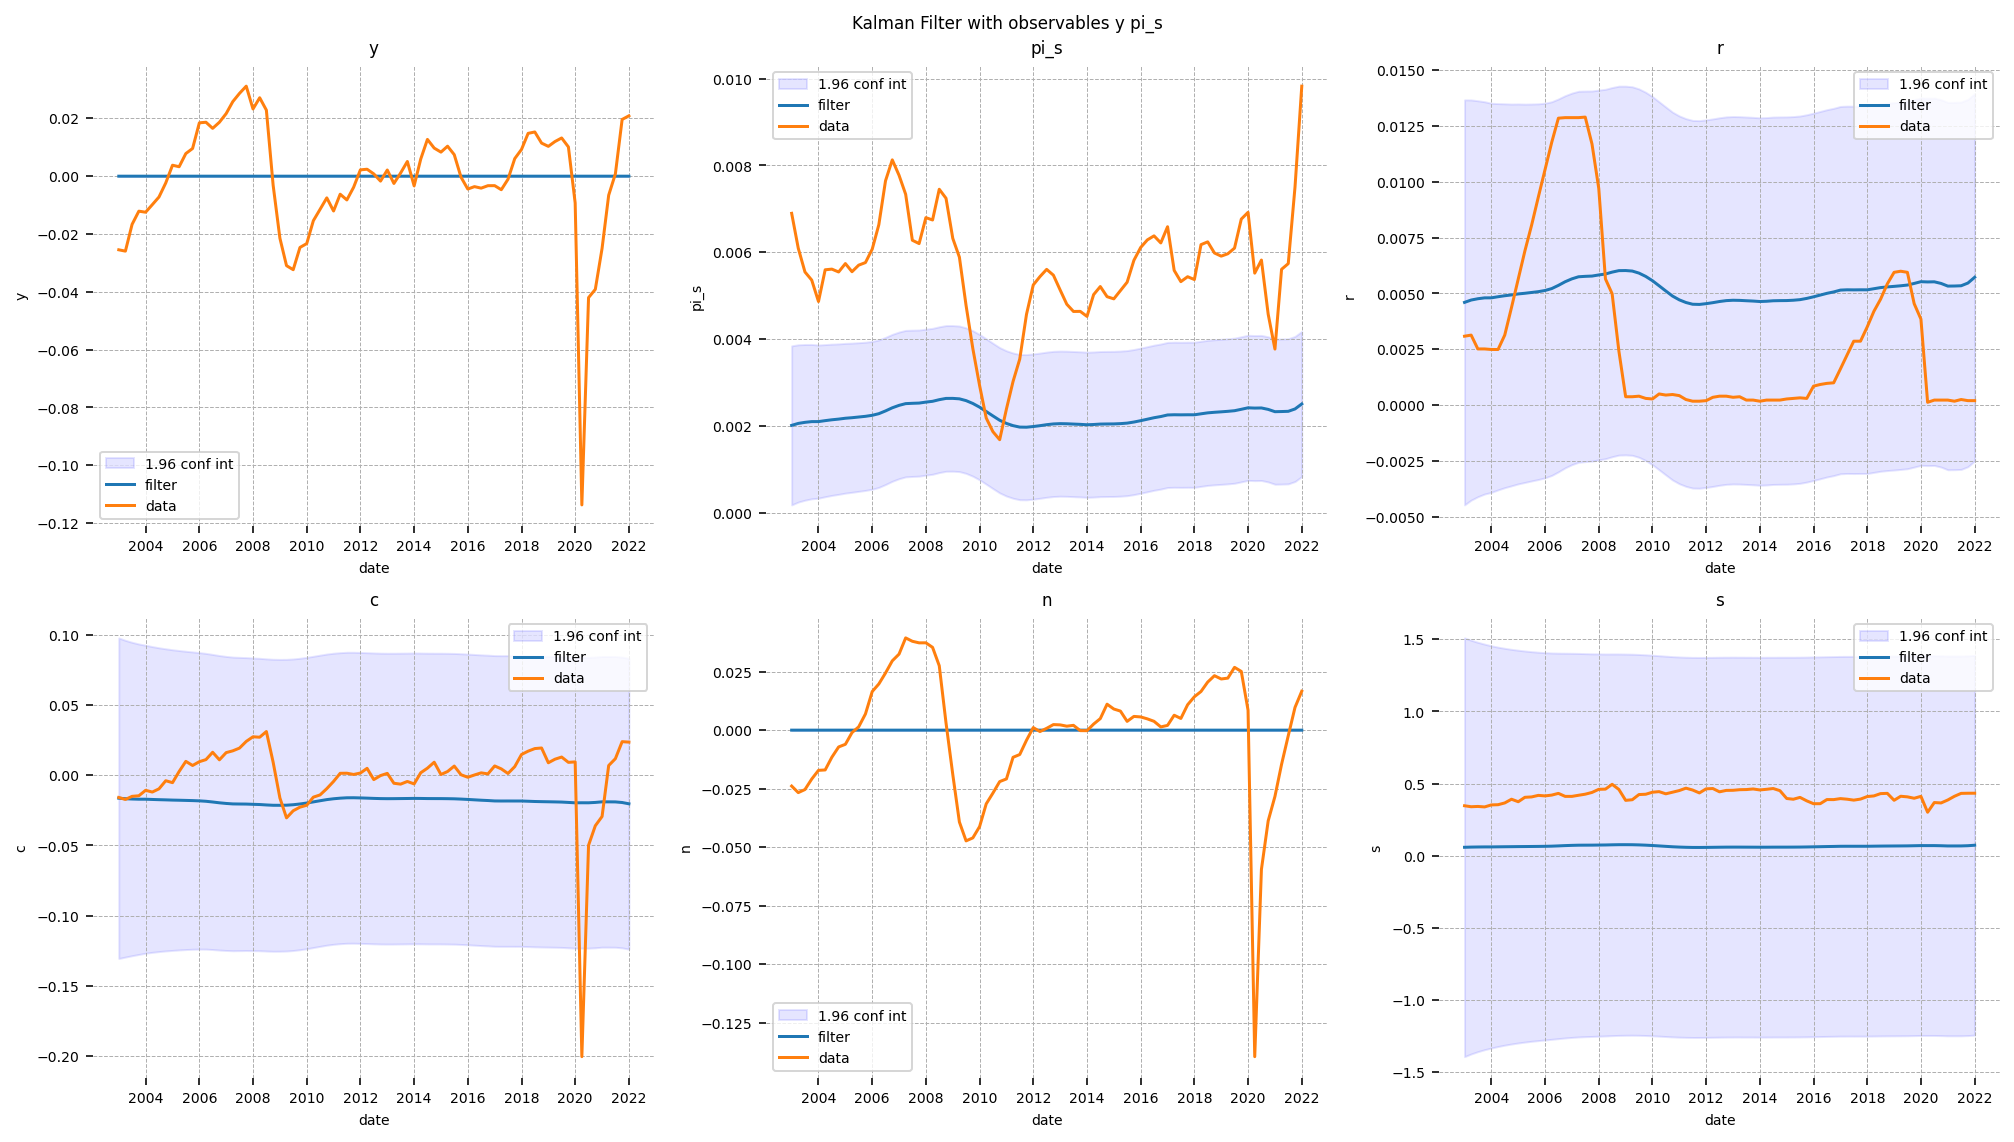

In [90]:
fig = plot_dfs(
    [
        mu_df_train[total_vars].iloc[ind_plot_start:],
        train[total_vars].iloc[ind_plot_start:], 
    ],
    plotfunc=sns.lineplot, 
    dfs_cov=[
         cov_df_train[total_vars].iloc[ind_plot_start:],
         None,
    ],
    legend=['filter', 'data'],
    cols=3,
    fig_title=f'Kalman Filter with observables {" ".join(str(x) for x in observed_vars)}',
);
fig.savefig(os.path.join(LATEX_OUT, f'{mod_name}_{"_".join(str(x) for x in observed_vars)}_kalman_filter.png'))

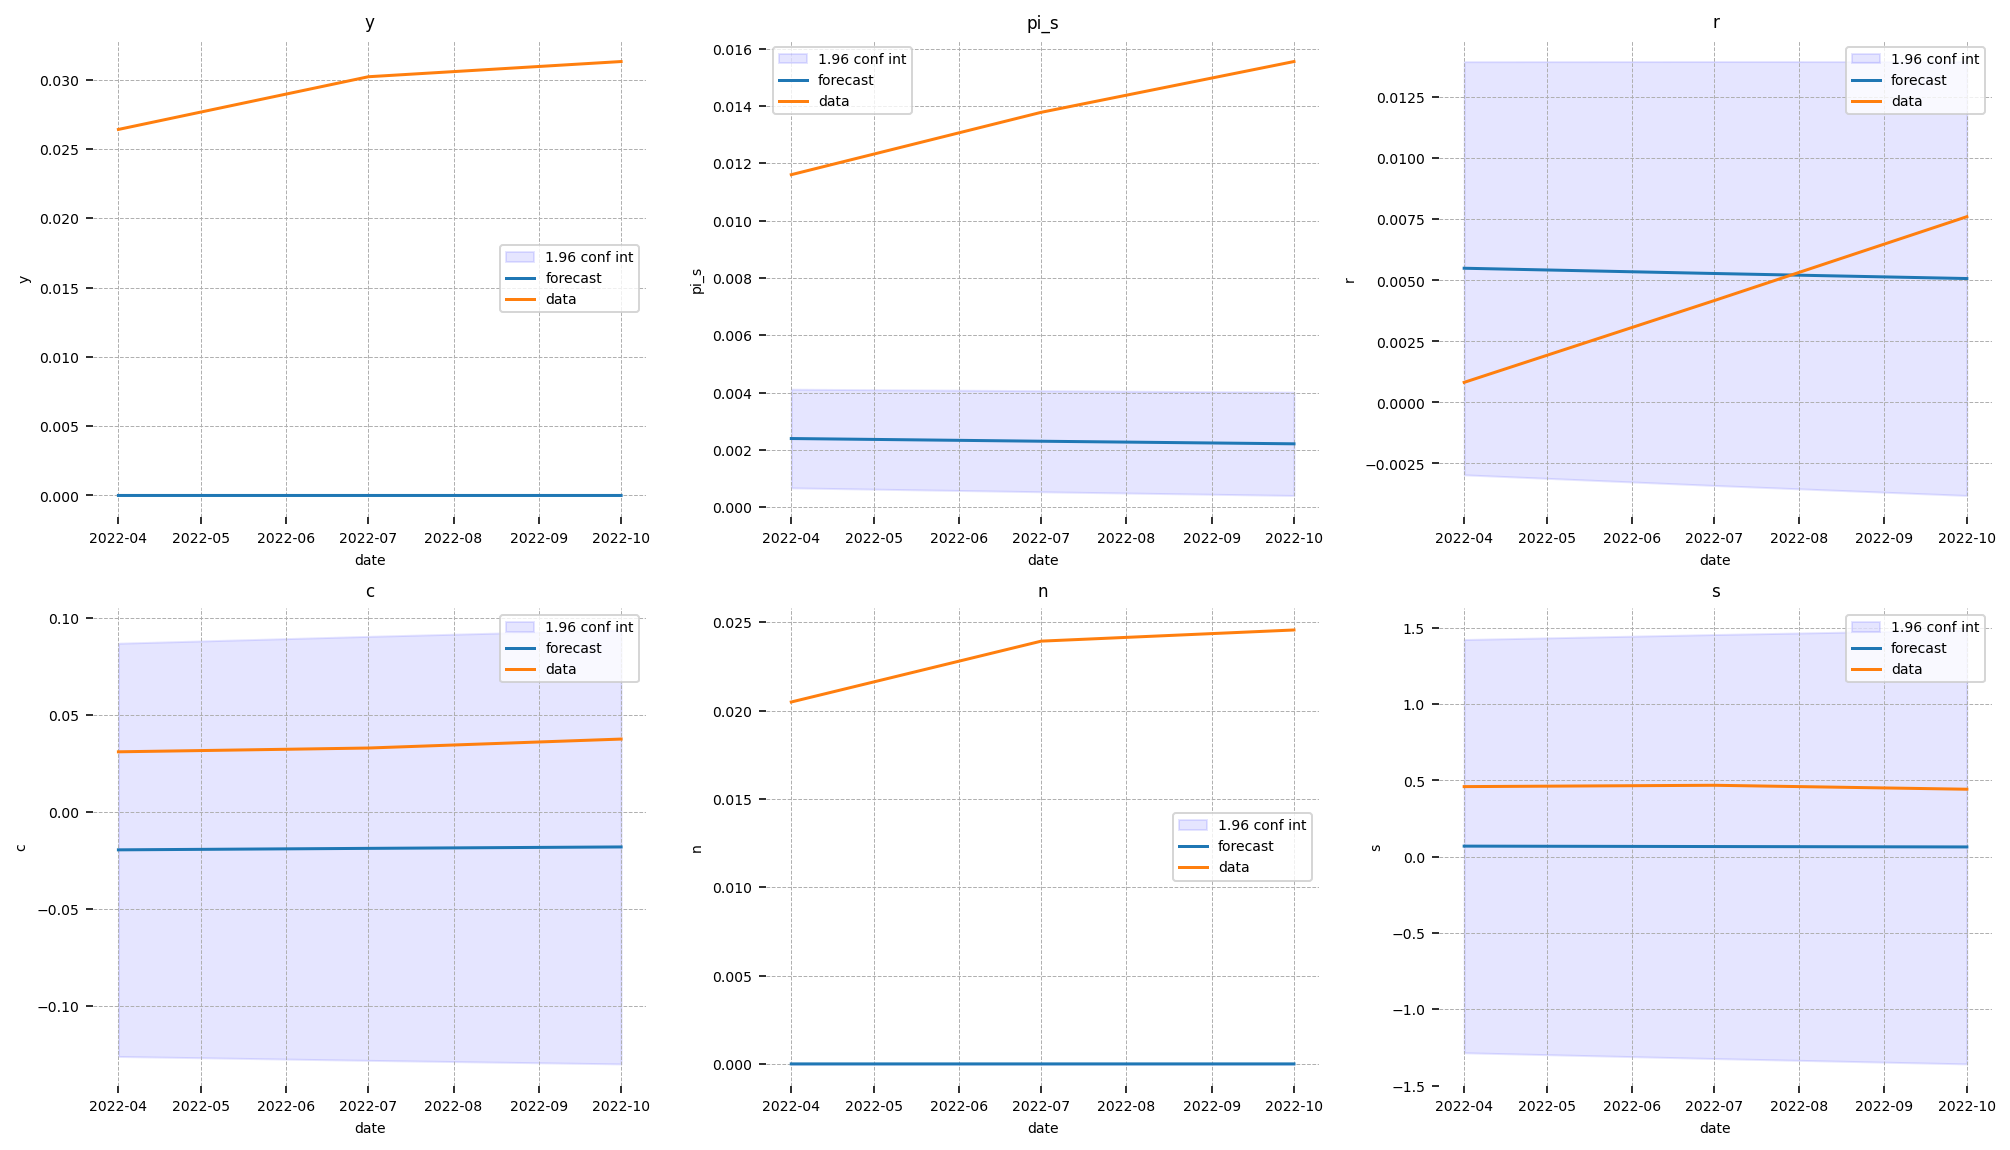

In [91]:
fig = plot_dfs(
    [
        mu_df_test[total_vars],
        test[total_vars]
    ], 
    sns.lineplot,
    dfs_cov=[cov_df_test, None],
    cols=3,
    legend=['forecast', 'data']
)
fig.savefig(os.path.join(LATEX_OUT, f'{mod_name}_{"_".join(str(x) for x in observed_vars)}_kalman_forecast_stable.png'))

In [97]:
forecast_dict = {
    'forecast': mu_df_test[total_vars],
    'true': test[total_vars]
}

import pickle 
with open(os.path.join(DATA_DIR, f'{mod_name}_{"_".join(str(x) for x in observed_vars)}_kalman_forecast.pkl'), 'wb') as f:
    pickle.dump(forecast_dict, f)

{'forecast':                    y      pi_s         r         c         n         s
 date                                                                  
 2022-04-01 -0.000001  0.002402  0.005500 -0.019527 -0.000006  0.069587
 2022-07-01 -0.000001  0.002308  0.005285 -0.018763 -0.000006  0.066864
 2022-10-01 -0.000001  0.002218  0.005078 -0.018029 -0.000005  0.064248,
 'true':                    y      pi_s         r         c         n         s
 date                                                                  
 2022-04-01  0.026403  0.011601  0.000824  0.031091  0.020492  0.459784
 2022-07-01  0.030205  0.013776  0.004174  0.033045  0.023939  0.468610
 2022-10-01  0.031302  0.015546  0.007613  0.037670  0.024571  0.442640}

In [98]:
with open(os.path.join(DATA_DIR, f'{mod_name}_{"_".join(str(x) for x in observed_vars)}_kalman_forecast.pkl'), 'rb') as f:
    loaded_dict = pickle.load(f)

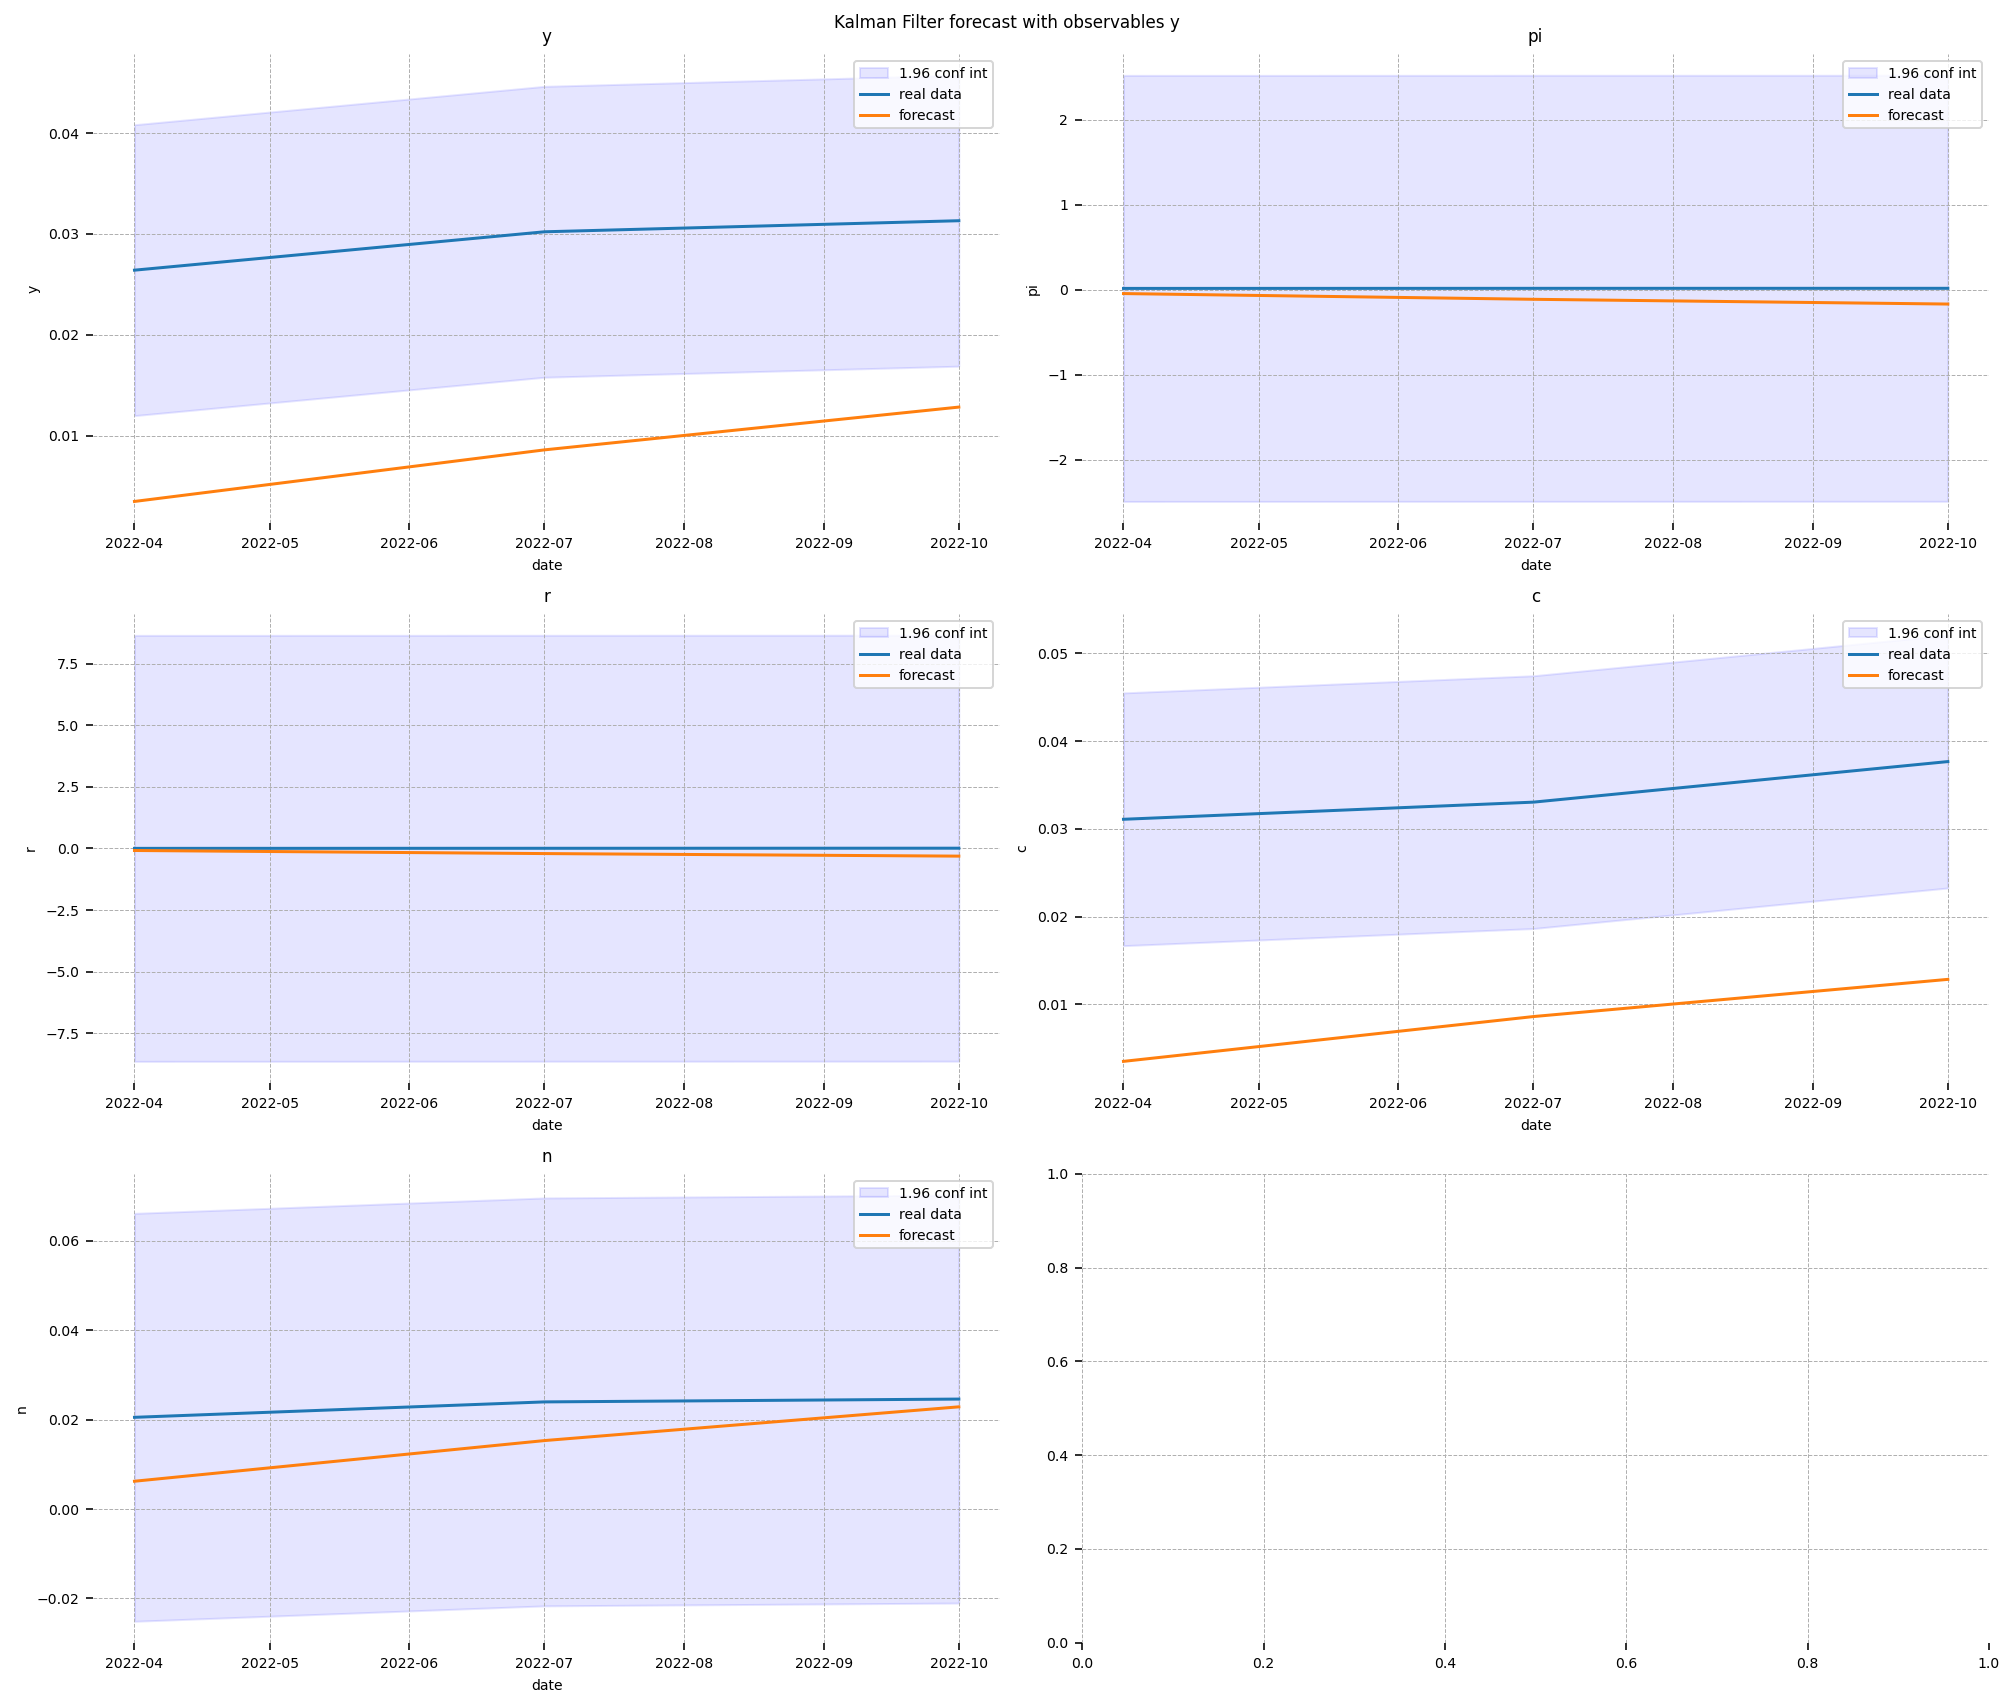

In [192]:
fig = plot_dfs(
    [
        # mu_df_train[total_vars].iloc[ind_plot_start:],
        # train[total_vars].iloc[ind_plot_start:], 
        test[total_vars], 
        mu_df_test[total_vars]
    ],
    plotfunc=sns.lineplot, 
    dfs_cov=[*chain(
        [cov_df_test[total_vars]],
        [None] * 1
    )], #[cov_df_test[total_vars]])], # * (n_draws + 2))],
    legend=['real data', 'forecast'], #, 'filter_test', 'data_test'],
    cols=2,
    # figsize=(20, 5),
    fig_title=f'Kalman Filter forecast with observables {" ".join(str(x) for x in observed_vars)}',
);

In [12]:







# get forecast
params = dict(zip(xarr.parameter.values, xarr.posterior_q2))
run_kalman_output = run_kalman_filter_forecast(mod, observed_vars, train[observed_vars], test[observed_vars], prior_dist, mod_params, params, observation_noise=observation_noise)
mu_df_train, cov_df_train, ll_test, mu_df_test, cov_df_test, ll_train = run_kalman_output

fig = plot_dfs(
    [mu_df_train[total_vars].iloc[ind_plot_start:], train[total_vars].iloc[ind_plot_start:], test[total_vars], mu_df_test[total_vars]],
    plotfunc=sns.lineplot, 
    dfs_cov=[*chain([cov_df_train[total_vars].iloc[ind_plot_start:]], [None] * (n_draws + 2))],
    # legend=['filter_train', 'data_train', 'filter_test', 'data_test'],
    cols=2,
    figsize=(20, 5),
    fig_title=f'{name} Kalman Filter',
)

fig.savefig(os.path.join(LATEX_OUT, f'{name}_kalman_forecast.png'))


mu_df_tests = []
for i in np.random.choice(xarr.draw, n_draws):
    params = dict(zip(xarr.parameter.values, xarr.sel(draw=i).posterior_param))
    _, _, _, mu_df_test, cov_df_test, ll_train = run_kalman_filter_forecast(mod, observed_vars, train[observed_vars], test[observed_vars], prior_dist, mod_params, params)
    mu_df_tests.append(mu_df_test[train[observed_vars].columns])


# plot results
# dfs = [mu_df_train[train.columns].iloc[ind_plot_start:], train.iloc[ind_plot_start:], test]
# dfs.extend(mu_df_tests)

# # plot_dfs(
#     dfs,
#     plotfunc=sns.lineplot, 
#     dfs_cov=[*chain([cov_df_train.iloc[ind_plot_start:]], [None] * (n_draws + 2))],
#     legend=['filter_train', 'data_train', 'filter_test', 'data_test'],
#     cols=2,
#     figsize=(20, 5),
#     fig_title=f'{name} Kalman Filter',
# )

KeyError: "None of [Index(['Y', 'S'], dtype='object')] are in the [columns]"